In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

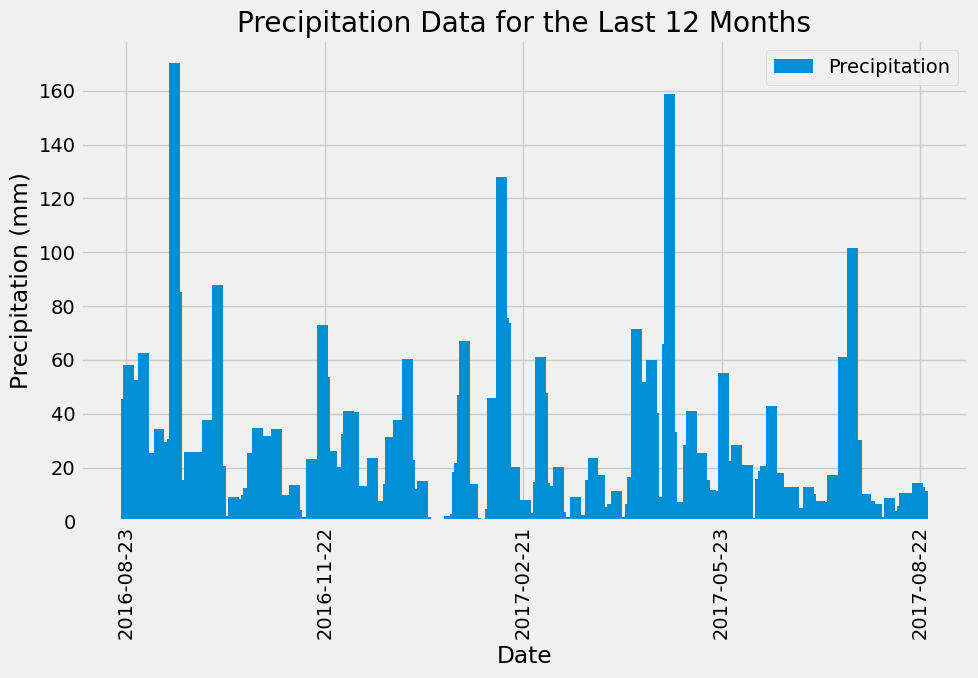

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]  

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = (most_recent_date - dt.timedelta(days=365)).date()


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df1 = precipitation_df.sort_values(by='Date', ascending=True)
precipitation_df1 = precipitation_df.groupby('Date')['Precipitation'].max().reset_index()

# Plot the precipitation data
plt.figure(figsize=(10, 7))
plt.bar(precipitation_df1['Date'], precipitation_df1['Precipitation'], label='Precipitation', width=5)
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Precipitation Data for the Last 12 Months")

# Customize x-axis ticks and labels for better readability with date formatting
x_ticks = np.arange(0, len(precipitation_df1), len(precipitation_df1) //4)  # Positions of the ticks
x_labels = [precipitation_df1['Date'].iloc[i] for i in x_ticks]  # Corresponding labels

plt.xticks(x_ticks, x_labels, rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics=pd.DataFrame(precipitation_df['Precipitation'].describe())
summary_statistics

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [47]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station from the previous query
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_stats

[(12.2, 29.4, 22.03582251082252)]

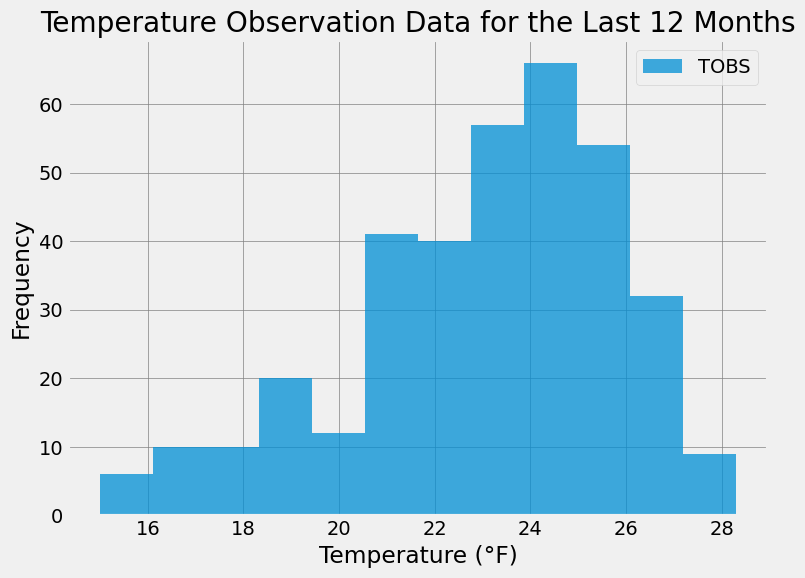

In [87]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date 12 months ago from the most recent date in the dataset
most_recent_date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = (most_recent_date - dt.timedelta(days=365)).date()


# # Query the temperature observations (TOBS) data for the most active station for the last 12 months
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
# tobs_data
# Create a DataFrame from the query results
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(tobs_df['Temperature'], bins=12, label='TOBS', alpha=0.75)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.legend()
plt.grid(True, color='gray', linewidth=0.5)
plt.tight_layout()
plt.show()

# Close Session

In [88]:
# Close Session
session.close()